# Evaluate "LLM as a Judge"

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
import seaborn as sns

# Configure Matplotlib for inline display
%matplotlib inline

In [3]:
# Choose which llm-as-a-judge data to evaluate
common_path = "../data/evaluations/"

llm_data = pd.read_csv(common_path + '2024-07-03-output_gpt35.csv')
# llm_data = pd.read_csv(common_path + '2024-07-03-output_gpt4.csv')

# This is from our sweat blood and tears
human_data = pd.read_csv(common_path + '2024-07-03-output_gpt4.csv')  # change later

In [4]:
llm_data.head()

,Transcript Number,Patient Name,"Dyspnea (shortness of breath) at rest, while walking or climbing stairs?",Paroxysmal Nocturnal Dyspnea (PND) (sudden shortness of breath at night),Orthopnea (shortness of breath while lying flat),Ankle edema or general lower extremity swelling (swelling in ankles or legs),Nocturnal cough (coughing at night),Chest pain,Fatigue,Worsening mental status that is acute (sudden confusion or mental changes),...,Did the doctor ask the patient what medications they are on?,Be sympathetic when the patient reports symptoms or pain.,"Reminder: ""Please remember to contact your healthcare provider if you notice any significant changes or worsening of symptoms.""",End the Conversation: Express care and encourage the patient to reach out if they need further assistance.,no premature end to conversation,Conversation flows naturally: no repetition,Patient uses plain language,Patient is consistent about their symptoms,Patient doesn’t invent information that contradicts the prompt (confabulations),Patient allows the doctor to ask questions and doesn’t take over direction of the conversation (offering information before it’s asked for)
0,19557627,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,1,1,1,1,1
1,19516114,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
2,18136989,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,1,1,1,1,1
3,17707918,1,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1
4,17566649,1,0,1,1,1,1,0,1,0,...,1,0,1,0,0,1,1,1,1,1


In [5]:
llm_data.columns.values

array(['Transcript Number', 'Patient Name',
       'Dyspnea (shortness of breath) at rest, while walking or climbing stairs?',
       'Paroxysmal Nocturnal Dyspnea (PND) (sudden shortness of breath at night)',
       'Orthopnea (shortness of breath while lying flat)',
       'Ankle edema or general lower extremity swelling (swelling in ankles or legs)',
       'Nocturnal cough (coughing at night)', 'Chest pain', 'Fatigue',
       'Worsening mental status that is acute (sudden confusion or mental changes)',
       'Temperature (body temperature)', 'Heart rate (pulse)',
       'Respiratory rate (number of breaths per minute)',
       'Oxygen saturation (oxygen level in the blood)',
       'Blood pressure (systolic and diastolic) (upper and lower blood pressure numbers)',
       'Weight (body weight)',
       'Did the doctor ask the patient what medications they are on?',
       'Be sympathetic when the patient reports symptoms or pain.',
       'Reminder: "Please remember to contact your

In [6]:
columns_matching = {
    "Transcript Number": "transcript_number",
    "Patient Name": "patient_name",
    "Dyspnea (shortness of breath)": "dyspnea",
    "Paroxysmal Nocturnal Dyspnea (PND)": "pnd",
    'Orthopnea': "orthopnea",
    'Ankle edema or general lower extremity swelling (swelling in ankles or legs)': "ankle_edema",
    'Nocturnal cough (coughing at night)': "nocturnal_cough",
    'Chest pain': "chest_pain",
    'Fatigue': "fatigue",
    'Worsening mental status that is acute (sudden confusion or mental changes)': "worsening_mental_status",
    'Temperature (body temperature)': "temperature",
    'Heart rate (pulse)': "heart_rate",
    'Respiratory rate (number of breaths per minute)': "respiratory_rate",
    'Oxygen saturation (oxygen level in the blood)': "oxygen_saturation",
    'Blood pressure (systolic and diastolic) (upper and lower blood pressure numbers)': "blood_pressure",
    'Weight (body weight)': "weight",
    'Did the doctor ask the patient what medications they are on?': "doctor_ask_medications",
    'Be sympathetic when the patient reports symptoms or pain.': "sympathetic_patient",
    'Reminder: "Please remember to contact your healthcare provider if you notice any significant changes or worsening of symptoms."': "reminder",
    'End the Conversation: Express care and encourage the patient to reach out if they need further assistance.': "end_conversation",
    'no premature end to conversation': "no_premature_end",
    'Conversation flows naturally: no repetition': "natural_conversation",
    'Patient uses plain language': "plain_language",
    'Patient is consistent about their symptoms': "consistent_symptoms",
    'Patient doesn’t invent information that contradicts the prompt (confabulations)': "no_confabulations",
    'Patient allows the doctor to ask questions and doesn’t take over direction of the conversation (offering information before it’s asked for)': "allow_doctor_questions"
}
short_columns = list(columns_matching.values())


def rename_columns(df):
    # find match, but note that columns only need to match the front part
    matched_columns = {}
    used_keys = []
    for col in df.columns:
        for key, value in columns_matching.items():
            if col.startswith(key) and col not in matched_columns:
                matched_columns[col] = value
                break

        if col not in matched_columns:
            print(f"Column {col} not matched")
    return df.copy().rename(columns=matched_columns)

llm_data = rename_columns(llm_data)
human_data = rename_columns(human_data)

/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:716: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/michaelenghoekhor/Libra

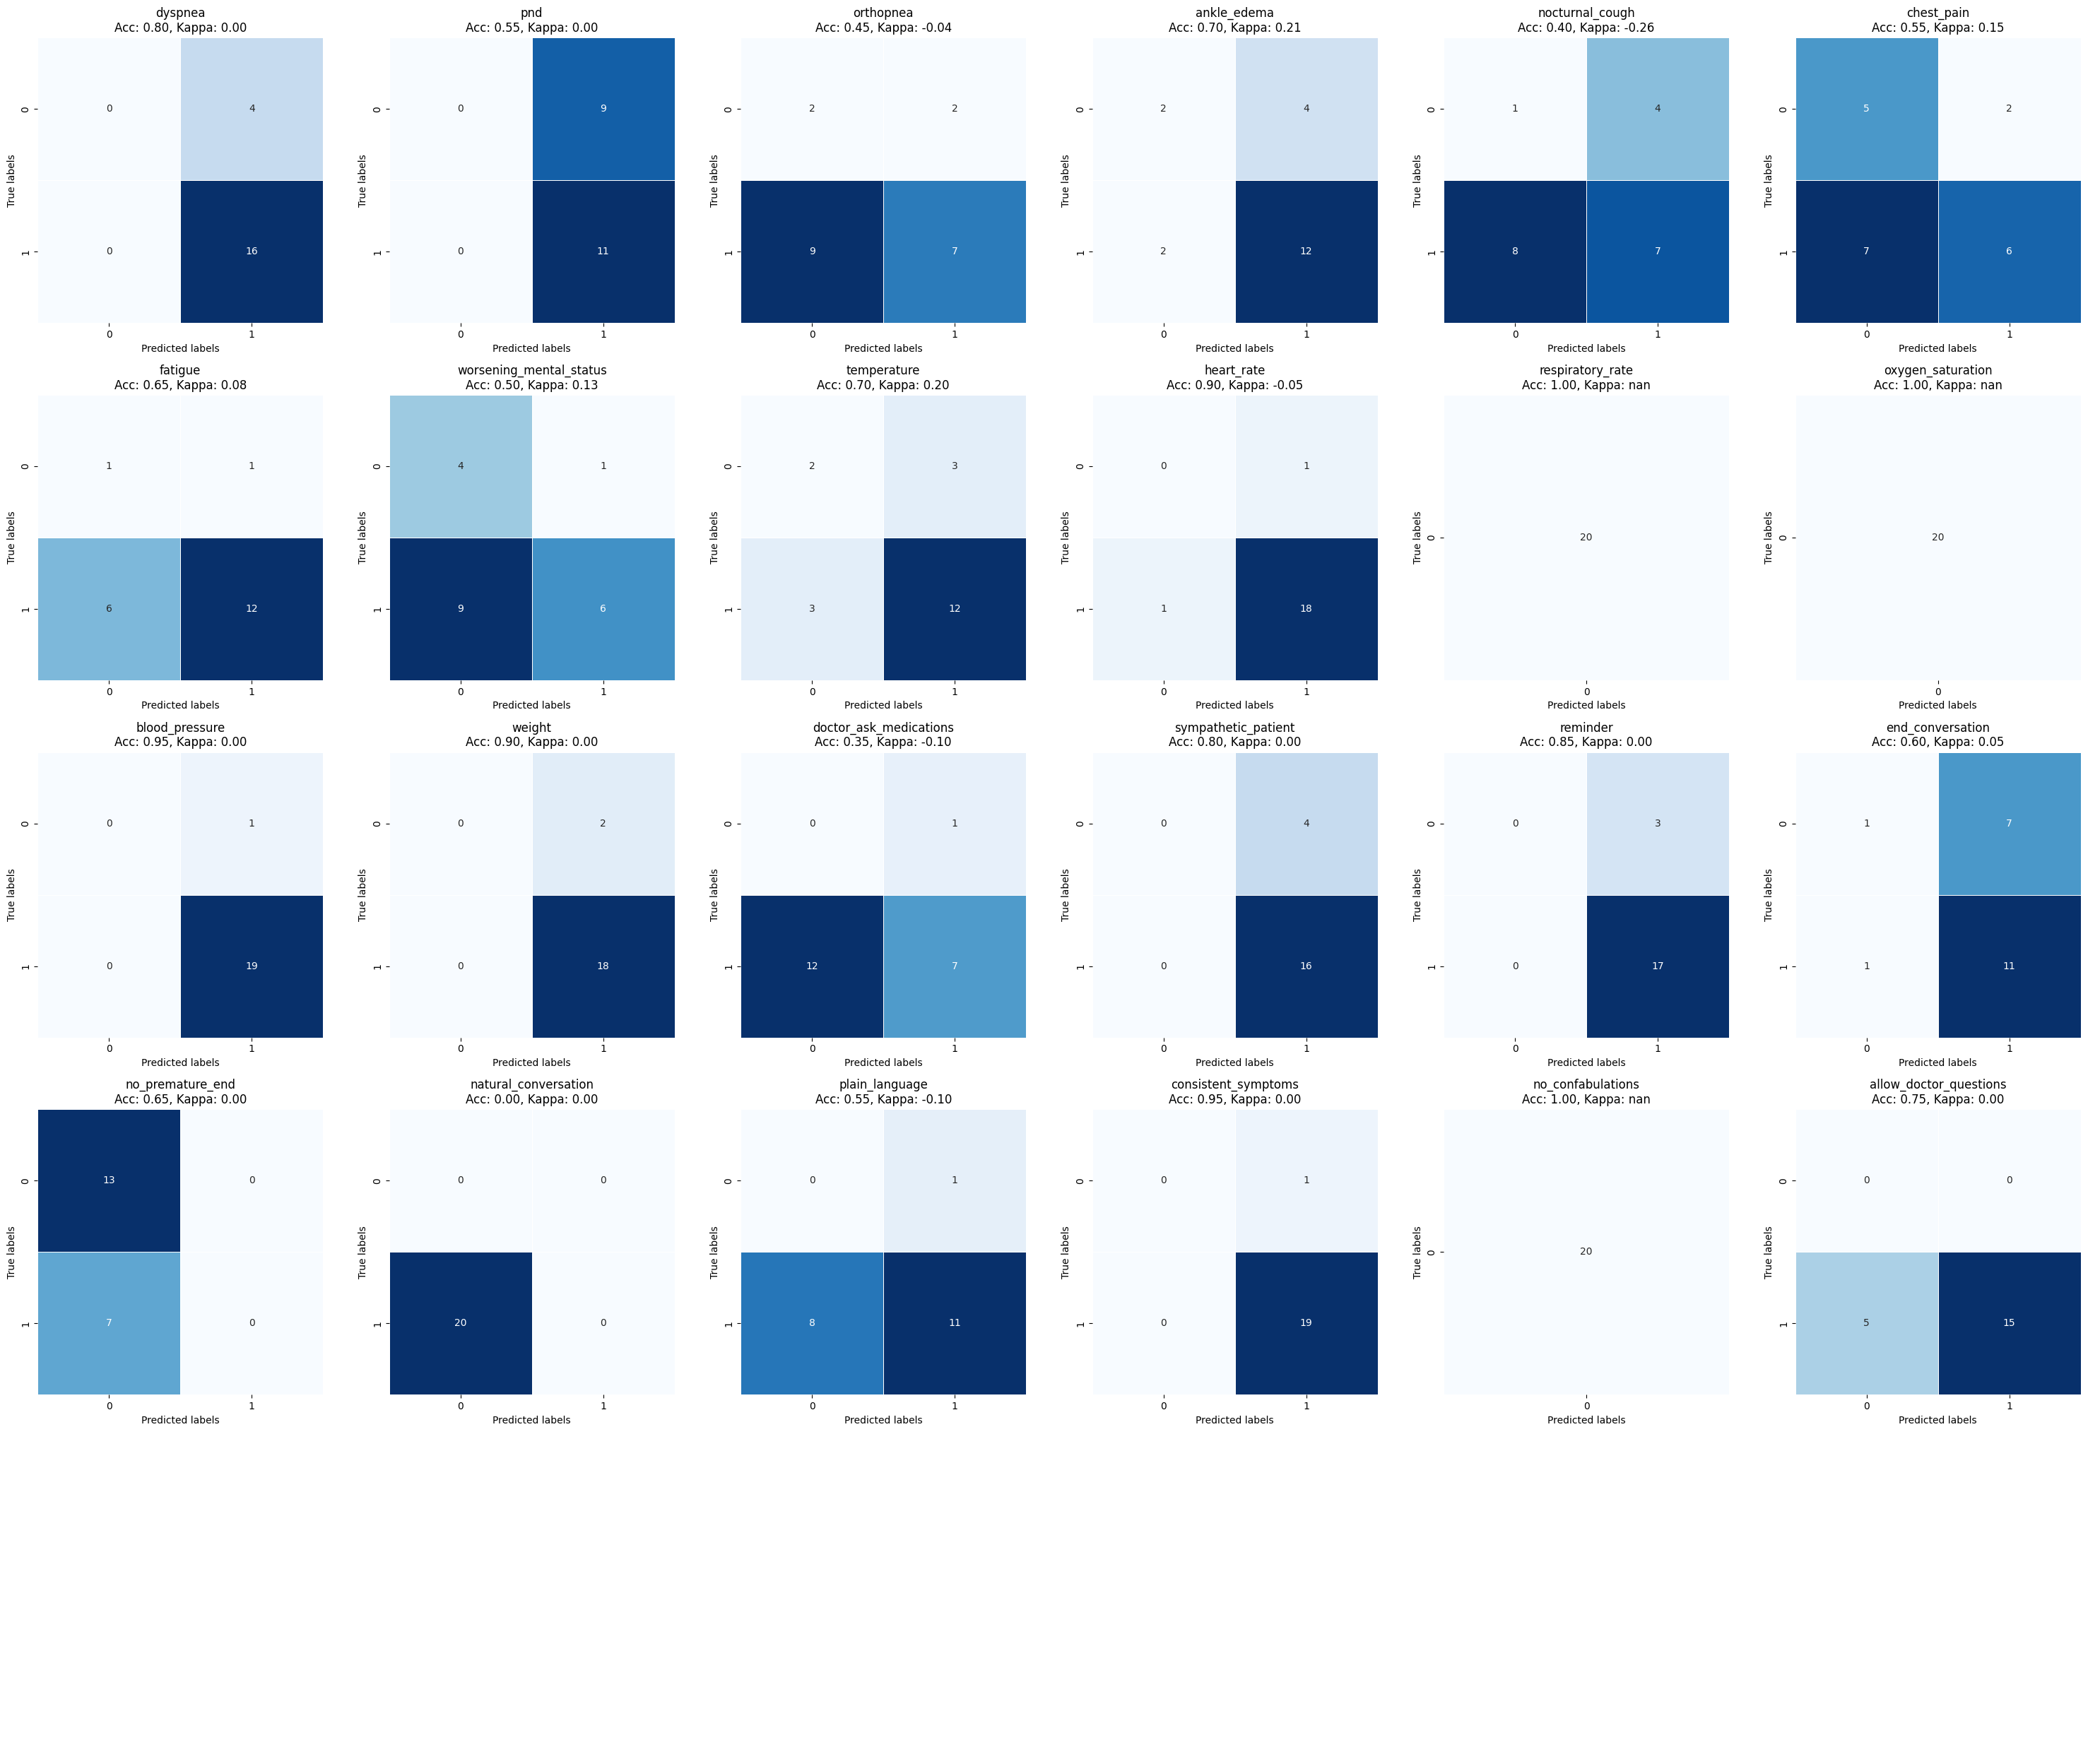

In [11]:
def plot_confusion_matrix(data1, data2, columns, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        cm = confusion_matrix(data1[col], data2[col])
        accuracy = accuracy_score(data1[col], data2[col])
        kappa = cohen_kappa_score(data1[col], data2[col])

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')
        axes[i].set_title(f'{col}\nAcc: {accuracy:.2f}, Kappa: {kappa:.2f}')

    # Hide any unused axes if there are any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for a specific column
feature_columns = short_columns[2:]
columns_per_row = 6
plot_confusion_matrix(llm_data, human_data, feature_columns, len(feature_columns) // columns_per_row + 1, columns_per_row)

## Other similarity metrics

In [8]:
# Pearson Correlation: Measures linear correlation between two datasets.
correlation = llm_data.iloc[:, 2:].corrwith(human_data.iloc[:, 2:])
print(correlation)

dyspnea                         NaN
pnd                             NaN
orthopnea                 -0.050252
ankle_edema                0.218218
nocturnal_cough           -0.290129
chest_pain                 0.171184
fatigue                    0.104828
worsening_mental_status    0.181568
temperature                0.200000
heart_rate                -0.052632
respiratory_rate                NaN
oxygen_saturation               NaN
blood_pressure                  NaN
weight                          NaN
doctor_ask_medications    -0.280976
sympathetic_patient             NaN
reminder                        NaN
end_conversation           0.068041
no_premature_end                NaN
natural_conversation            NaN
plain_language            -0.187317
consistent_symptoms             NaN
no_confabulations               NaN
allow_doctor_questions          NaN
dtype: float64


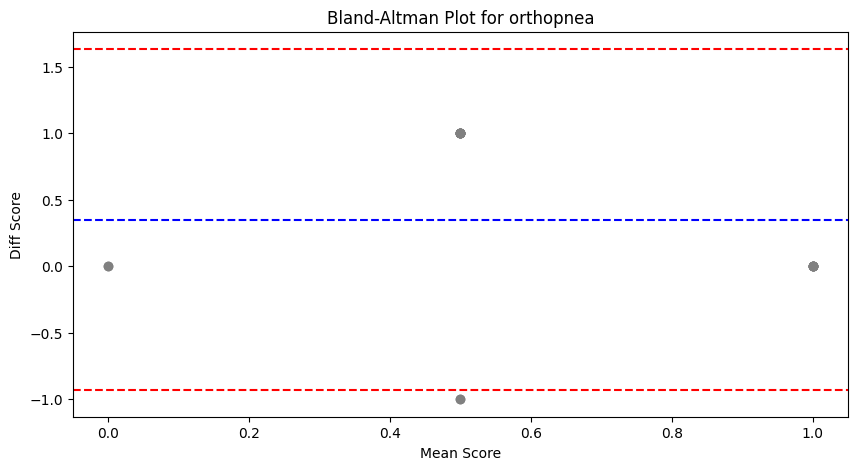

In [9]:
# Bland-Altman Plot: Used to compare two sets of measurements -- not a good measure

# You can write a function to plot Bland-Altman for a specific feature.
def bland_altman_plot(data1, data2, col):
    mean = np.mean([data1[col], data2[col]], axis=0)
    diff = data1[col] - data2[col]
    md = np.mean(diff)
    sd = np.std(diff, axis=0)

    plt.figure(figsize=(10, 5))
    plt.scatter(mean, diff, color='gray')
    plt.axhline(md, color='blue', linestyle='--')
    plt.axhline(md + 1.96 * sd, color='red', linestyle='--')
    plt.axhline(md - 1.96 * sd, color='red', linestyle='--')
    plt.title(f'Bland-Altman Plot for {col}')
    plt.xlabel('Mean Score')
    plt.ylabel('Diff Score')
    plt.show()

# Example usage
bland_altman_plot(llm_data, human_data, llm_data.columns[4])